In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#|hide
from nbdev import show_doc, nbdev_export

# Match-phase experiments

> How to choose match-phase operator based on the time and quality trade-off.

In a [previous post](https://vespa-engine.github.io/learntorank/passage_uncertainty_evaluation.html), we described how to measure uncertainty around metric estimates when running search engine experiments. We illustrated the methodology using the ms marco passage ranking dataset.

## Introduction

There are basically three options to choose from when selecting the method to match text fields to text queries using lexical matching. 

1. The `AND` operator (`grammar: all` in Vespa) match the documents that contains *all* of the query terms.

2. The `OR` operator (`grammar: any` in Vespa) match the documents that contains *at least one* of the query terms.

3. The `weakAND` operator (`grammar: weakAnd`) attempts to match the best scoring documents without exhaustive scoring all documents which matches any of the terms in the query.

The intuition from the definitions above is that the `AND` operator will match fewer documents leading to fast responses but low recall while the `OR` operator will match more documents leading to slow response but higher recall. The hope with the `weakAND` operator is to dratically reduce the number of matched documents without a significant impact on recall. **The best way to understand those trade-offs is to make experiments.**

## Match-phase experiments

We are going to use the [passage ranking dataset](https://vespa-engine.github.io/learntorank/passage_dataset.html) to build a text search application and run the experiments shown here. The code and the data used in this end-to-end tutorial are available and can be reproduced in a Jupyter Notebook. The core of the experiments is based on the [learntorank](https://github.com/vespa-engine/learntorank) library.

### Evaluation metrics

In [ ]:
from learntorank.evaluation import (
    MatchRatio,
    TimeQuery,
    Recall, 
    ReciprocalRank, 
)

We want to measure the number of the documents matched as a percentage of the size of the document corpus (`MatchRatio`) and the time it takes to perform a query (`TimeQuery`). In addition, we want one metric to evaluate recall (`Recall`) and one to evaluate precision (`ReciprocalRank`).

In [ ]:
metrics = [
    MatchRatio(),
    TimeQuery(),
    Recall(at=100), 
    ReciprocalRank(at=10), 
]

### Text search app and feed data

Create a Vespa application package to perform passage ranking experiments using a basic search app with lexical search functionality.

In [ ]:
from learntorank.passage import create_basic_search_package

app_package = create_basic_search_package()

The passage ranking dataset used here contains 8.841.823 text passages. When performing experiments, we don't need to use the full dataset to arrive at statistically significant results. We will report results for three corpus size scenarios:

In [ ]:
corpus_size = [10000, 100000, 1000000]

When sampling the corpus, we will mantain the proportion of dev queries to corpus size observed in the full dataset.

In [ ]:
ratio_devquery_corpus = 55578/8841823
print(
    f"Ratio between dev queries and corpus size: {ratio_devquery_corpus:.4f}"
)

Ratio between dev queries and corpus size: 0.0063


### QueryModel: AND and OR operator

A `QueryModel` encapsulates all the information required to match and rank documents. The code below specify two query models using the `bm25` metric as the ranking function. One query model uses the `AND`operator while the other uses the `OR` operator.

In [ ]:
from learntorank.query import QueryModel, AND, OR, Ranking

query_models = [
    QueryModel(
        name="and_bm25", 
        match_phase=AND(), 
        ranking=Ranking(name="bm25")
    ),
    QueryModel(
        name="or_bm25", 
        match_phase=OR(), 
        ranking=Ranking(name="bm25")
    )
]

### WeakAnd operator

As mentioned in the introduction of this post, the `WeakAnd` operator gives a trade-off between the `AND` and the `OR` operator. It allow us to specify the number of `hits` to be returned, giving a lever to balance between query time and result's quality, as we will see in the experiment results. 

To check the effect of the `hits` parameter on the metrics followed by our experiments, we decided to create three query models based on the `WeakAnd` operator by varying the `hits` parameter.

In [ ]:
from learntorank.query import WeakAnd

query_models.extend(
    [
        QueryModel(
            name="weakand_10_bm25", 
            match_phase=WeakAnd(hits=10), 
            ranking=Ranking(name="bm25")
        ),
        QueryModel(
            name="weakand_100_bm25", 
            match_phase=WeakAnd(hits=100),
            ranking=Ranking(name="bm25")
        ),
        QueryModel(
            name="weakand_1000_bm25", 
            match_phase=WeakAnd(hits=1000), 
            ranking=Ranking(name="bm25")
        )
    ]
)        

### Tokenize operator

The `Tokenize` operator (`grammar: tokenize` in Vespa) is similar to the `WeakAnd` operator in functionality. Except that no characters, such as minus or quote signs carry any semantics in this mode, any non-searchable character is simply ignored. This is useful when querying using text not explicitly written as a search query.

In the passage ranking case, where the text are cleaned and the sentences are short, we expect similar results whe comparing `WeakAnd` and `Tokenize` but the differences might be significant for other messier text datasets.

In [ ]:
from learntorank.query import Tokenize

query_models.extend(
    [
        QueryModel(
            name="tokenize_10_bm25", 
            match_phase=Tokenize(hits=10), 
            ranking=Ranking(name="bm25")
        ),
        QueryModel(
            name="tokenize_100_bm25", 
            match_phase=Tokenize(hits=100), 
            ranking=Ranking(name="bm25")
        ),
        QueryModel(
            name="tokenize_1000_bm25",
            match_phase=Tokenize(hits=1000), 
            ranking=Ranking(name="bm25")
        )
    ]
)

## Experiment results

The `evaluate_query_models` function will loop through the different `corpus_size` values that we specified and:

* Deploy the application defined by the `app_package` that we specified. 

* Sample the appropriate number of data points from the original passage dataset.

* Feed the sampled data to the deployed app.

* Evaluate the `query_models` according to the selected `metrics`

* Append the current iteration results in the `output_file_path`.

We need to add `presentation.timing = "true"` to each query to have query time information available to the `TimeQuery` operator.

In [ ]:
from learntorank.passage import evaluate_query_models

estimates = evaluate_query_models(
    app_package=app_package,
    query_models=query_models,
    metrics=metrics,
    corpus_size=corpus_size,
    output_file_path="passage_match_phase.csv", 
    **{"presentation.timing": "true"}
)

### Plot functions

We will use the following function to display experiment results.

In [ ]:
from plotnine import *

def plot_metrics(estimates):
    estimates = estimates.copy()
    estimates.metric = estimates.metric.astype("category")
    estimates.metric = estimates.metric.cat.reorder_categories(
        ["search_time", "match_ratio", 
         "recall_100", "reciprocal_rank_10"]
    )
    return (
        ggplot(estimates, aes(colour = "model")) + 
        scale_x_log10(
            breaks=list(estimates.corpus_size.unique()), 
            labels=list(estimates.corpus_size.unique())
        ) + 
        theme(
            panel_grid_minor=element_blank(),
            subplots_adjust={'wspace': 0.15},
            legend_position = 'top'
        ) +
        geom_point(aes(x = "corpus_size", y = "median")) + 
        geom_line(aes(x = "corpus_size", y = "median")) + 
        geom_errorbar(aes(x="corpus_size", ymin="low",ymax="high")) + 
        facet_wrap("metric", scales="free_y") + labs(y="Metric value")
    )

In [ ]:
import pandas as pd

estimates = pd.read_csv(
    "../data_learntorank/passage_sample_size_tokenize.csv"
)

In [ ]:
estimates = estimates[
    estimates.metric.isin(
        ["search_time", 
         "match_ratio", 
         "recall_100", 
         "reciprocal_rank_10"
        ]
    )
]

### Comparing AND and OR

In [ ]:
and_or = estimates.loc[
    estimates.model.isin(["and_bm25", "or_bm25"])
]

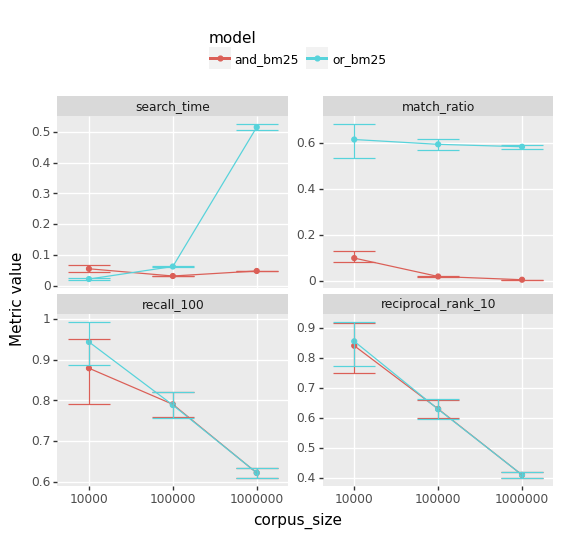

In [ ]:
print(plot_metrics(and_or))

### Comparing WeakAnd hits

In [ ]:
weakand_hits = estimates.loc[
    estimates.model.str.contains("weakand")
]

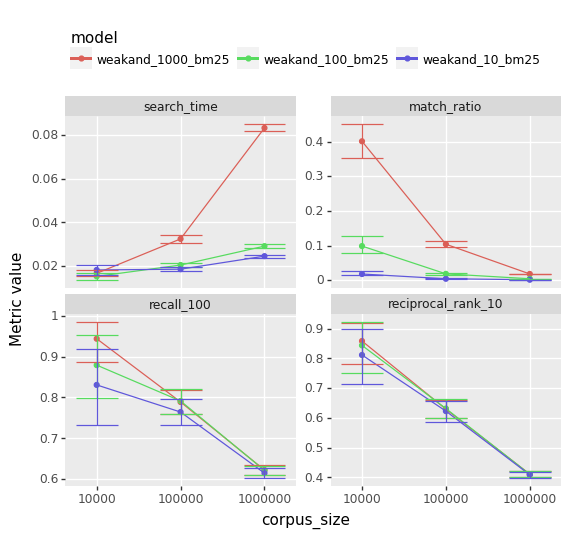

In [ ]:
print(plot_metrics(weak_and_hits))

# Comparing best WeakAnd with AND

In [ ]:
and_weakand = estimates.loc[
    estimates.model.isin(["and_bm25", "weakand_10_bm25"])
]

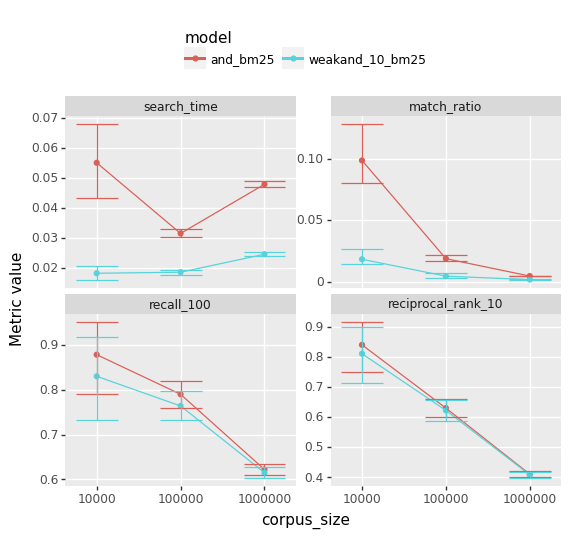

In [ ]:
print(plot_metrics(and_weakand))

[Vespa 8](https://docs.vespa.ai/en/vespa8-release-notes.html) changed the default match phase used for text matching, which affects how text fields are matched when compared with a text query. Vespa 7 used `all` by default, where it would match documents only if it contained every query term in the searched field.

## Queries to document corpus ratio

In [ ]:
import pandas as pd
import numpy as np

estimates = pd.read_csv("../data_learntorank/passage_sample_size_tokenize.csv")

In [ ]:
estimates

,metric,model,low,median,high,corpus_size,number_queries
0,match_ratio,and_bm25,0.079810,0.098449,0.128048,10000,62
1,match_ratio,or_bm25,0.533923,0.613232,0.680577,10000,62
2,match_ratio,tokenize_1000_bm25,0.079558,0.099129,0.130496,10000,62
3,match_ratio,tokenize_100_bm25,0.079003,0.098992,0.126782,10000,62
4,match_ratio,tokenize_10_bm25,0.079476,0.098050,0.127144,10000,62
...,...,...,...,...,...,...,...
115,search_time,tokenize_100_bm25,0.031814,0.032603,0.033446,1000000,6285
116,search_time,tokenize_10_bm25,0.050140,0.051434,0.052727,1000000,6285
117,search_time,weakand_1000_bm25,0.081691,0.083300,0.085111,1000000,6285
118,search_time,weakand_100_bm25,0.028443,0.029154,0.029903,1000000,6285


In [ ]:
#estimates[["corpus_size", "number_queries"]] = estimates[["corpus_size", "number_queries"]].apply(pd.to_numeric)

In [ ]:
#print(estimates[estimates.corpus_size.apply(lambda x: isinstance(x, str))])

In [ ]:
#print(estimates[pd.to_numeric(estimates.corpus_size, errors='coerce').isnull()])

In [ ]:
#estimates.iloc[0]

In [ ]:
#estimates.dtypes

In [ ]:
#bm25_vs_native_rank = estimates.loc[estimates.model.isin(["bm25", "native_rank"])]

In [ ]:
#bm25_vs_native_rank.describe()

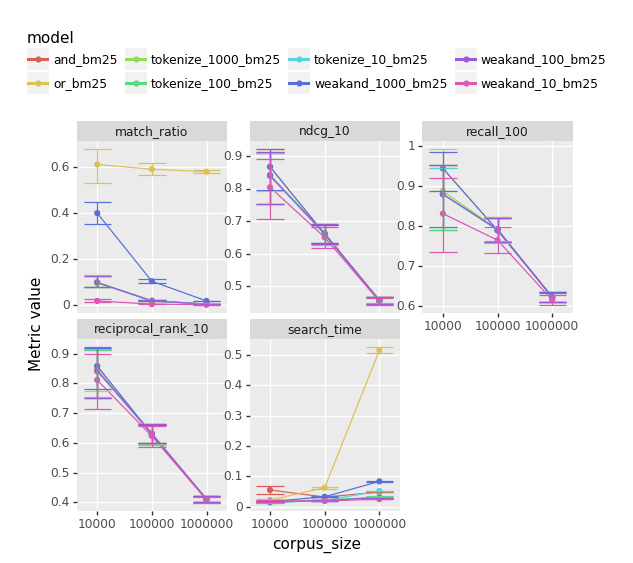

In [ ]:
print(plot_metrics(estimates))

In [ ]:
print(plot_metrics(bm25_vs_native_rank))

NameError: name 'bm25_vs_native_rank' is not defined

In [ ]:
weak_and_estimates = estimates.loc[~estimates.model.isin(["native_rank"])]

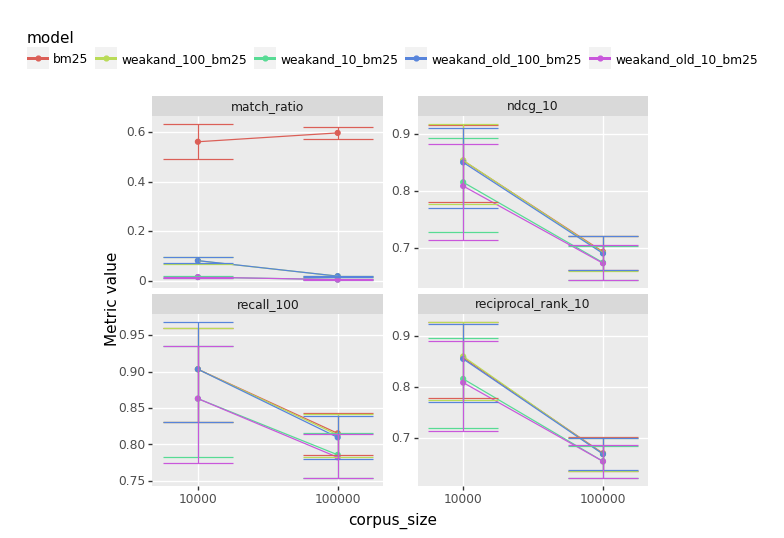

In [ ]:
print(plot_metrics(weak_and_estimates))

In [ ]:
weak_and_estimates

In [ ]:
weakand_1000000_estimates = weak_and_estimates.loc[weak_and_estimates.corpus_size == 1000000]

In [ ]:
(ggplot(weakand_1000000_estimates) + 
 #scale_x_log10(breaks=list(estimates.corpus_size.unique()), labels=list(estimates.corpus_size.unique())) + 
 theme(
     panel_grid_minor=element_blank(),
     axis_text_x=element_text(rotation=90, hjust=1),
    subplots_adjust={'wspace': 0.25},
    legend_position = 'top'
) +
geom_point(aes(x = "model", y = "median")) + 
geom_line(aes(x = "model", y = "median")) + 
geom_errorbar(aes(x="model", ymin="low",ymax="high")) + 
facet_wrap("metric", scales="free_y") + labs(y="Metric value")
)

## TODO

* Eu vou usar OR como match phase e dps faco uma analise com hits do weakAND

* Incluir o timing como comparar OR e weakAnd

## Cleanup the environment

In [ ]:
vespa_docker.container.stop(timeout=600)
vespa_docker.container.remove()

NameError: name 'vespa_docker' is not defined

In [ ]:
#|hide
nbdev_export()